In [12]:
from astropy.table import Table

import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import ks_2samp


import sys
sys.path.insert(1, '/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/')

from mass_ratio_plottingFunctions import DM_SM_hist

In [13]:
#IMAGE_DIR = 'C:/Users/jacob/Documents/GitHub/RotationCurves/images'
IMAGE_DIR = '/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/images'

#master_table = Table.read( 'C:/Users/jacob/Documents/GitHub/RotationCurves/master_file.txt', format='ascii.ecsv')
master_table = Table.read('../master_file_vflag_10.txt', format='ascii.ecsv')

In [14]:
'''
###########################################################################
# Remove galaxies with t3 < 2, BPT == 1 (star-forming)
#--------------------------------------------------------------------------
temp_boolean = master_table['t3'] <= 3
BPT_boolean = master_table['BPT'] == 1

good_galaxies = master_table[temp_boolean & BPT_boolean]
###########################################################################
'''
good_galaxies = master_table


###########################################################################
# Split galaxies into "walls" and "voids"
#--------------------------------------------------------------------------
vboolean = good_galaxies['vflag'].data == 1
wboolean = good_galaxies['vflag'].data == 0

void_table = good_galaxies[vboolean]
wall_table = good_galaxies[wboolean]
other_table = good_galaxies[np.logical_not(vboolean | wboolean)]
###########################################################################


###########################################################################
# Separate the mass ratios according to wall or void
#--------------------------------------------------------------------------
dm_to_stellar_mass_ratio_wall = wall_table['Mdark_Mstar_ratio'].data
dm_to_stellar_mass_ratio_void = void_table['Mdark_Mstar_ratio'].data

dm_to_stellar_mass_ratio_err_wall = wall_table['Mdark_Mstar_ratio_error'].data
dm_to_stellar_mass_ratio_err_void = void_table['Mdark_Mstar_ratio_error'].data

Z12logOH_wall = wall_table['Z12logOH_N2O2']
Z12logOH_void = void_table['Z12logOH_N2O2']

logNO_wall = wall_table['logNO']
logNO_void = void_table['logNO']
###########################################################################


###########################################################################
# Hard-coded entry for the bins for the histrogram plots at the end of this
#    function.
#--------------------------------------------------------------------------
hist_range = (7, 11)
bins = np.linspace( hist_range[0], hist_range[1], 10)
###########################################################################


###########################################################################
# Initialize table to store the number of galaxies in each bin of the 
# histogram(s).
#--------------------------------------------------------------------------
count_table = Table()

# First column is the bins
count_table['Bins'] = bins[1:]
###########################################################################

## Plot formatting

In [15]:
#plt.rc('text', usetex=True)
plt.rc('font', size=16)#family='serif')
lwidth = 2 # Line width used in plots

## Abundance histogram function

In [16]:
def abundance_hist(void, wall, abundance, 
                   save_fig=False, FILE_ABUND='', FILE_SUFFIX='', IMAGE_DIR='', IMAGE_FORMAT='eps'):
    '''
    Histogram the abundance ratio as separated by environment


    Parameters:
    ===========

    void : numpy array of shape (n, )
        Abundance ratios for void galaxies

    wall : numpy array of shape (m, )
        Abundance ratios for wall galaxies

    save_fig : boolean
        Flag to determine whether or not the figure should be saved.  Default 
        is False (do not save).
        
    FILE_ABUND : string
        Abundance string to be used in file name.  Default is '' (nothing).

    FILE_SUFFIX : string
        Additional information to include at the end of the figure file name.  
        Default is '' (nothing).

    IMAGE_DIR : string
        Address to directory to save file.  Default is current directory.

    IMAGE_FORMAT : string
        Format for saved image.  Default is 'eps'
    '''

    ###########################################################################
    # Initialize figure and axes
    #--------------------------------------------------------------------------
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)
    ###########################################################################


    ###########################################################################
    # Plot histograms in first figure
    #--------------------------------------------------------------------------
    ax1.hist( void, bins, color='r', range=hist_range, density=True, 
             histtype='step', linewidth=lwidth, 
             label='Void: ' + str( np.sum( np.isfinite( void))))

    ax1.hist( wall, bins, color='k', range=hist_range, density=True, 
             histtype='step', linewidth=lwidth, linestyle=':', 
             label='Wall: ' + str( np.sum( np.isfinite( wall))))
    #--------------------------------------------------------------------------
    # Histogram plot formatting
    #--------------------------------------------------------------------------
    ax1.set_xlabel(abundance)
    ax1.set_ylabel('Galaxy fraction')
    ax1.set_title(abundance + ' Distribution')
    
    ax1.tick_params( axis='both', direction='in')
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.set_xlim( hist_range)
    #ax1.set_ylim( (0, 0.15))
    #ax1.set_xticks( BINS)

    ax1.legend(loc=2)
    ###########################################################################


    ###########################################################################
    # Plot CDF in second figure
    #--------------------------------------------------------------------------
    # KS test
    ks_stat, p_val = ks_2samp( wall, void)
    #--------------------------------------------------------------------------
    ax2.hist( void, bins=1000, range=hist_range, density=True, 
             cumulative=True, histtype='step', color='r', linewidth=lwidth, label='Void')
    ax2.hist( wall, bins=1000, range=hist_range, density=True, 
             cumulative=True, histtype='step', color='k', linewidth=lwidth, linestyle=':', 
             label='Wall')
    #--------------------------------------------------------------------------
    # CDF plot formatting
    #--------------------------------------------------------------------------
    ax2.set_xlabel(abundance)
    ax2.set_ylabel('Galaxy fraction')
    ax2.set_title(abundance + ' CDF')
    
    ax2.tick_params( axis='both', direction='in')
    ax2.yaxis.set_ticks_position('both')
    ax2.xaxis.set_ticks_position('both')
    ax2.set_xlim( hist_range)
    #ax2.set_xticks( BINS)
    
    ax2.legend(loc='upper left')

    ax2.text( (hist_range[1] - hist_range[0]) * 0.65 + hist_range[0], 0.15, 
             "p-val: " + "{:.{}f}".format( p_val, 3))
    ###########################################################################
    
    
    ###########################################################################
    # Save figure?
    #--------------------------------------------------------------------------
    if save_fig:
        plt.savefig( IMAGE_DIR + '/histograms/' + FILE_ABUND + '_hist' + file_suffix + '.' + IMAGE_FORMAT,
                    format=IMAGE_FORMAT)
    ###########################################################################

## Function to calculate shift between populations

In [17]:
def calculate_shift(void, wall, void_errors, wall_errors):
    '''
    Calculate the average shift between the void and wall populations.
    
    
    Parameters:
    ===========
    
    void_ratios : numpy array of shape (n_void,)
        Array of the mass ratios for the void galaxies
        
    wall_ratios : numpy array of shape (n_wall,)
        Array of the mass ratios for the wall galaxies
        
    void_ratio_errors : numpy array of shape (n_void,)
        Array of the errors in the mass ratios for the void galaxies
        
    wall_ratio_errors : numpy array of shape (n_wall,)
        Array of the errors in the mass ratios for the wall galaxies
    '''
    
    #######################################################################
    # Calculate averages, shift between voids and walls
    #----------------------------------------------------------------------
    v_mean = np.mean(void)
    w_mean = np.mean(wall)

    v_median = np.median(void)
    w_median = np.median(wall)

    mean_diff = v_mean - w_mean
    median_diff = v_median - w_median
    #######################################################################


    #######################################################################
    # Calculate uncertainties in the (average) shifts
    #----------------------------------------------------------------------
    # Preserve only finite elements for error calculation
    v_finite = void_errors[np.isfinite(void_errors)]
    w_finite = wall_errors[np.isfinite(wall_errors)]

    v_mean_err = np.sqrt(np.sum(v_finite**2))/len(v_finite)
    w_mean_err = np.sqrt(np.sum(w_finite**2))/len(w_finite)

    mean_diff_err = np.sqrt(v_mean_err**2 + w_mean_err**2)
    #######################################################################


    print('The average difference between the two populations is', mean_diff, 'pm', mean_diff_err)
    print('The median difference between the two populations is', median_diff)

# Histogram of ratio of dark matter halo mass to stellar mass for all galaxies

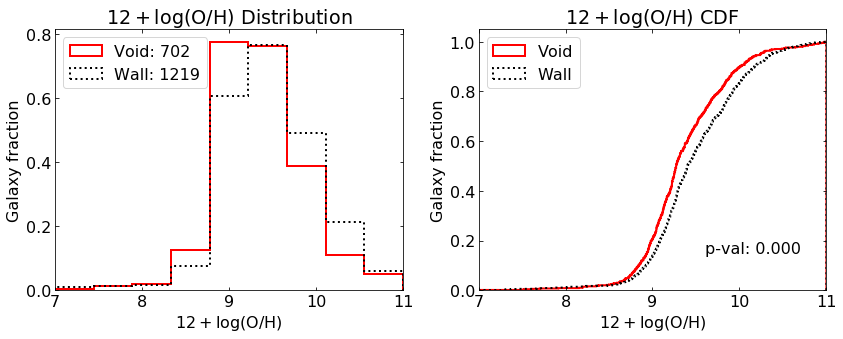

In [18]:
abundance_hist(void_table['Z12logOH_N2O2'], wall_table['Z12logOH_N2O2'], '$12 + \log$(O/H)')

# Bin by metallicity

### Low metallicity (Z < 7.6)

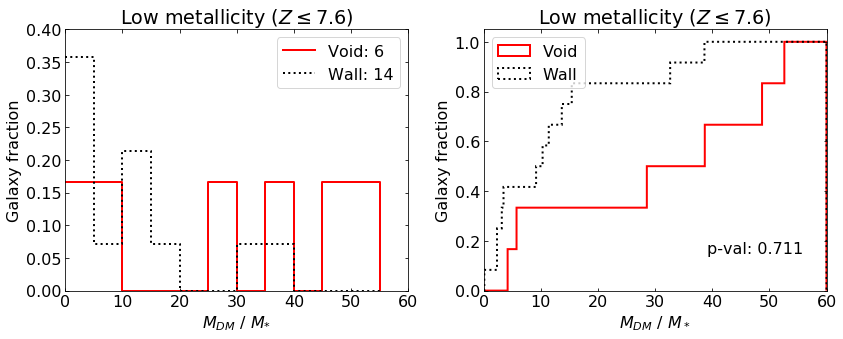

In [19]:
vboolean = void_table['Z12logOH_N2O2'] <= 7.6
wboolean = wall_table['Z12logOH_N2O2'] <= 7.6

###########################################################################
# Separate the mass ratios according to wall or void.
#--------------------------------------------------------------------------
low_wall = wall_table['Mdark_Mstar_ratio'][wboolean].data
low_void = void_table['Mdark_Mstar_ratio'][vboolean].data
###########################################################################


###########################################################################
# Add population counts to histogram table
#--------------------------------------------------------------------------
count_table['v_low'], _ = np.histogram(low_void, bins)
count_table['w_low'], _ = np.histogram(low_wall, bins)
###########################################################################

DM_SM_hist(low_void, low_wall, y_max=0.4, plot_title='Low metallicity ($Z \leq 7.6$)')

### Middle metallicity (7.6 < Z < 8.2)

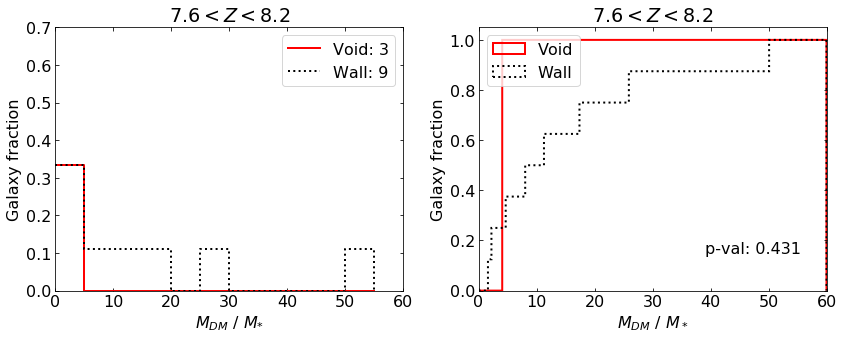

In [20]:
vboolean = np.logical_and(void_table['Z12logOH_N2O2'] > 7.6, void_table['Z12logOH_N2O2'] < 8.2)
wboolean = np.logical_and(wall_table['Z12logOH_N2O2'] > 7.6, wall_table['Z12logOH_N2O2'] < 8.2)

###########################################################################
# Separate the mass ratios according to wall or void.
#--------------------------------------------------------------------------
mid_wall = wall_table['Mdark_Mstar_ratio'][wboolean].data
mid_void = void_table['Mdark_Mstar_ratio'][vboolean].data
###########################################################################


###########################################################################
# Add population counts to histogram table
#--------------------------------------------------------------------------
count_table['v_mid'], _ = np.histogram(mid_void, bins)
count_table['w_mid'], _ = np.histogram(mid_wall, bins)
###########################################################################

DM_SM_hist(mid_void, mid_wall, y_max=0.7, plot_title='$7.6 < Z < 8.2$')

### High metallicity (Z > 8.2)

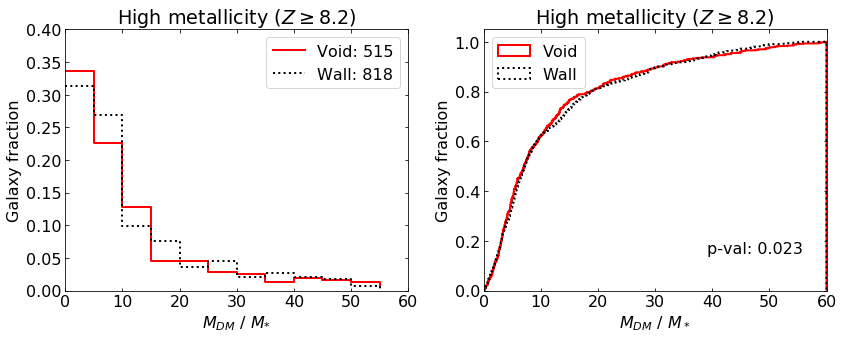

In [21]:
vboolean = void_table['Z12logOH_N2O2'] >= 8.2
wboolean = wall_table['Z12logOH_N2O2'] >= 8.2

###########################################################################
# Separate the mass ratios according to wall or void.
#--------------------------------------------------------------------------
high_wall = wall_table['Mdark_Mstar_ratio'][wboolean].data
high_void = void_table['Mdark_Mstar_ratio'][vboolean].data
###########################################################################


###########################################################################
# Add population counts to histogram table
#--------------------------------------------------------------------------
count_table['v_high'], _ = np.histogram(high_void, bins)
count_table['w_high'], _ = np.histogram(high_wall, bins)
###########################################################################

DM_SM_hist(high_void, high_wall, y_max=0.4, plot_title='High metallicity ($Z \geq 8.2$)')

## Write histogram table to file

In [ ]:
count_table.write('abundance_hist_counts.txt', format='ascii.commented_header')

## Relationship between mass ratio and metallicity

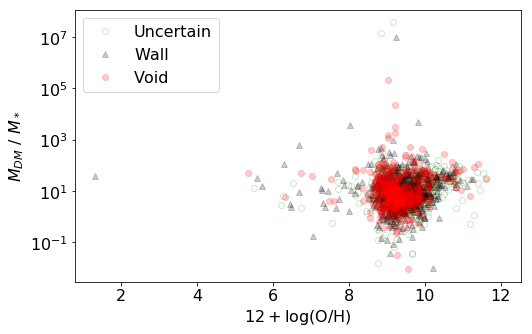

In [22]:
plt.figure(figsize=(8,5))

plt.semilogy(other_table['Z12logOH_N2O2'], other_table['Mdark_Mstar_ratio'], 'go', fillstyle='none', alpha=0.2, label='Uncertain')
plt.semilogy(wall_table['Z12logOH_N2O2'], wall_table['Mdark_Mstar_ratio'], 'k^', alpha=0.2, label='Wall')
plt.semilogy(void_table['Z12logOH_N2O2'], void_table['Mdark_Mstar_ratio'], 'ro', alpha=0.2, label='Void')

plt.xlabel('$12 + \log$(O/H)')
plt.ylabel('$M_{DM}$ / $M_*$')

plt.legend()